# =============================================================================
# STEP 2: RFM SEGMENTATION
# Calculate Recency, Frequency, Monetary values for customer scoring
# =============================================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. LOAD CLEANED DATA (from Step 1 EDA)

In [3]:

df = pd.read_csv('../data/processed/online_retail_cleaned.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"Unique customers: {df['CustomerID'].nunique()}")


Dataset shape: (407661, 9)
Date range: 2009-12-01 07:45:00 to 2010-12-09 20:01:00
Unique customers: 4311


## 2. CALCULATE RFM METRICS

In [6]:
# Reference date: day after last transaction (for recency calculation)
reference_date = df['InvoiceDate'].max() + timedelta(days=1)
print(f"\nReference date for recency: {reference_date}")

# Calculate RFM for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency: days since last purchase
    'InvoiceNo': 'nunique',                                       # Frequency: number of orders
    'TotalAmount': ['sum', 'mean', 'count']                     # Monetary: total spent
}).reset_index()

# Flatten column names
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'TotalItems']

# Remove customers with negative or zero monetary (returns/cancellations already filtered)
rfm = rfm[rfm['Monetary'] > 0]
rfm = rfm[rfm['Frequency'] > 0]

print(f"\nRFM Dataset shape: {rfm.shape}")
print("\nRFM Summary Statistics:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())


Reference date for recency: 2010-12-10 20:01:00

RFM Dataset shape: (4311, 6)

RFM Summary Statistics:
           Recency    Frequency       Monetary
count  4311.000000  4311.000000    4311.000000
mean     91.132220     4.456275    2040.074826
std      96.836908     8.170877    8897.677431
min       1.000000     1.000000       2.950000
25%      18.000000     1.000000     307.975000
50%      53.000000     2.000000     705.650000
75%     136.000000     5.000000    1722.565000
max     374.000000   205.000000  349164.350000


## 3. RFM SCORING (1-5 Scale)

In [7]:
# Use quintiles (20% percentiles) for scoring
# Recency: Lower is better (recent purchase), so we reverse the score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
# Frequency: Higher is better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
# Monetary: Higher is better  
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Convert to numeric
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Combined RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Average RFM Score (simple segmentation)
rfm['RFM_Avg'] = (rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']) / 3

print("\nRFM Score Distribution:")
print(rfm[['R_Score', 'F_Score', 'M_Score']].mean())


RFM Score Distribution:
R_Score    3.025284
F_Score    2.999536
M_Score    2.999536
dtype: float64


## 4. MANUAL SEGMENTATION (Business Logic)

In [8]:
def segment_customers(row):
    """Segment customers based on RFM scores using business rules"""
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r >= 3 and f <= 2 and m >= 3:
        return 'Potential Loyalists'
    elif r <= 2 and f >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m >= 3:
        return 'Cannot Lose Them'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customers, axis=1)

## 5. VISUALIZATION: RFM DISTRIBUTIONS

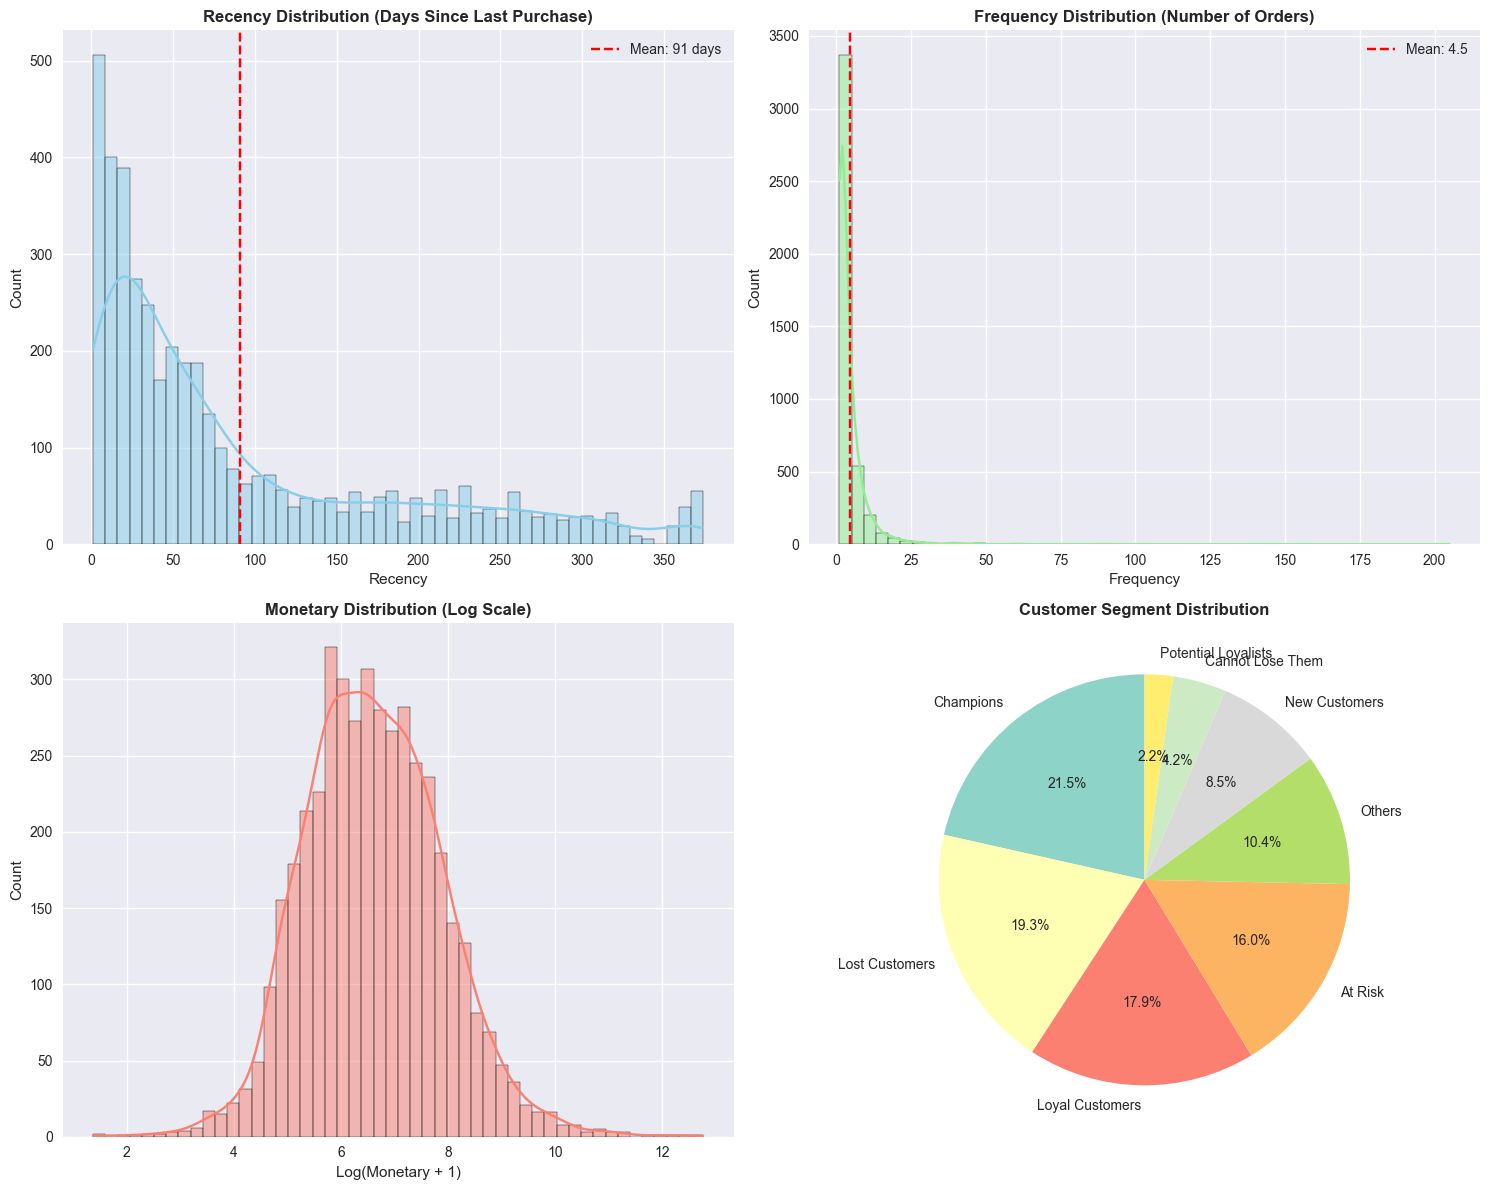

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Recency distribution
sns.histplot(rfm['Recency'], bins=50, kde=True, ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Recency Distribution (Days Since Last Purchase)', fontsize=12, fontweight='bold')
axes[0,0].axvline(rfm['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Recency"].mean():.0f} days')
axes[0,0].legend()

# Frequency distribution
sns.histplot(rfm['Frequency'], bins=50, kde=True, ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Frequency Distribution (Number of Orders)', fontsize=12, fontweight='bold')
axes[0,1].axvline(rfm['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Frequency"].mean():.1f}')
axes[0,1].legend()

# Monetary distribution (log scale for skewness)
sns.histplot(np.log1p(rfm['Monetary']), bins=50, kde=True, ax=axes[1,0], color='salmon')
axes[1,0].set_title('Monetary Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('Log(Monetary + 1)')

# Segment counts
segment_counts = rfm['Segment'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(segment_counts)))
axes[1,1].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1,1].set_title('Customer Segment Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/rfm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. SEGMENT ANALYSIS TABLE

In [10]:
segment_analysis = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum'],
    'AvgOrderValue': 'mean'
}).round(2)

segment_analysis.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue', 'Avg_Order_Value']
segment_analysis['Percentage'] = (segment_analysis['Count'] / len(rfm) * 100).round(1)
segment_analysis = segment_analysis.sort_values('Total_Revenue', ascending=False)

print("\n" + "="*80)
print("SEGMENT ANALYSIS (Business Insights)")
print("="*80)
print(segment_analysis)

# Calculate revenue percentage
segment_analysis['Revenue_Percentage'] = (segment_analysis['Total_Revenue'] / segment_analysis['Total_Revenue'].sum() * 100).round(1)
print("\nRevenue by Segment:")
print(segment_analysis[['Count', 'Percentage', 'Revenue_Percentage', 'Avg_Monetary']])


SEGMENT ANALYSIS (Business Insights)
                     Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
Segment                                                                
Champions              926        13.66          11.68       6170.55   
Loyal Customers        772        37.70           4.23       1608.61   
At Risk                688       149.02           3.75       1499.41   
Cannot Lose Them       181       183.92           1.38       1161.18   
Lost Customers         833       220.34           1.07        226.78   
New Customers          368        19.79           1.30        503.75   
Others                 447        42.73           1.78        301.90   
Potential Loyalists     96        56.03           1.42        916.51   

                     Total_Revenue  Avg_Order_Value  Percentage  
Segment                                                          
Champions               5713925.00            34.66        21.5  
Loyal Customers         1241846.78         

## 7. SAVE RFM DATA FOR NEXT STEP (CLUSTERING)

In [11]:
rfm.to_csv('../data/processed/rfm_data.csv', index=False)
print("\n✅ RFM data saved to: ../data/processed/rfm_data.csv")

# Also create a summary for SQL validation
rfm_summary = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'Segment']]
rfm_summary.to_csv('../data/processed/rfm_summary.csv', index=False)


✅ RFM data saved to: ../data/processed/rfm_data.csv
